In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix

In [2]:
df = pd.read_csv('diabetes_dataset.csv') 
if 'Fasting_Blood_Glucose' in df.columns:
    df['Diabetes'] = df['Fasting_Blood_Glucose'].apply(lambda x: 1 if x > 125 else 0)
    print('Target column Diabetes created based on Fasting_Blood_Glucose.')
else:
    print('Fasting_Blood_Glucose column not found. Please check the dataset.')
    
X = df.drop('Diabetes', axis=1)
y = df['Diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Target column Diabetes created based on Fasting_Blood_Glucose.


In [3]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [25]:
n_features = X_train_processed.shape[1]
model = Sequential([
    Dense(32, activation='relu', input_shape=(n_features,)),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid') 
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

c:\Users\kalas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train_processed, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5710 - loss: 0.7186 - val_accuracy: 0.9237 - val_loss: 0.3077
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8465 - loss: 0.3467 - val_accuracy: 0.9712 - val_loss: 0.1161
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9131 - loss: 0.2067 - val_accuracy: 0.9787 - val_loss: 0.0713
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9340 - loss: 0.1524 - val_accuracy: 0.9844 - val_loss: 0.0555
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9510 - loss: 0.1175 - val_accuracy: 0.9856 - val_loss: 0.0436
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9671 - loss: 0.0853 - val_accuracy: 0.9900 - val_loss: 0.0361
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9732 - loss: 0.0695 - val_accuracy: 0.9875 - val_loss: 0.0325
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9713 - loss: 0.0726 - val_accu

In [34]:

# Predict probabilities and class labels
y_pred_prob = model.predict(X_test_processed).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


In [33]:
loss, accuracy = model.evaluate(X_test_processed, y_test)
print(f"Test accuracy: {accuracy:.5f}")

# Detailed Accuracy Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Precision, Recall, and F1-Score details
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nPrecision, Recall, and F1-Score:")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")
print(f"F1-Score: {f1:.5f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - accuracy: 0.9988 - loss: 0.0061
Test accuracy: 0.99800

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       851
           1       1.00      1.00      1.00      1149

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


Precision, Recall, and F1-Score:
Precision: 0.99739
Recall: 0.99652
F1-Score: 0.99695


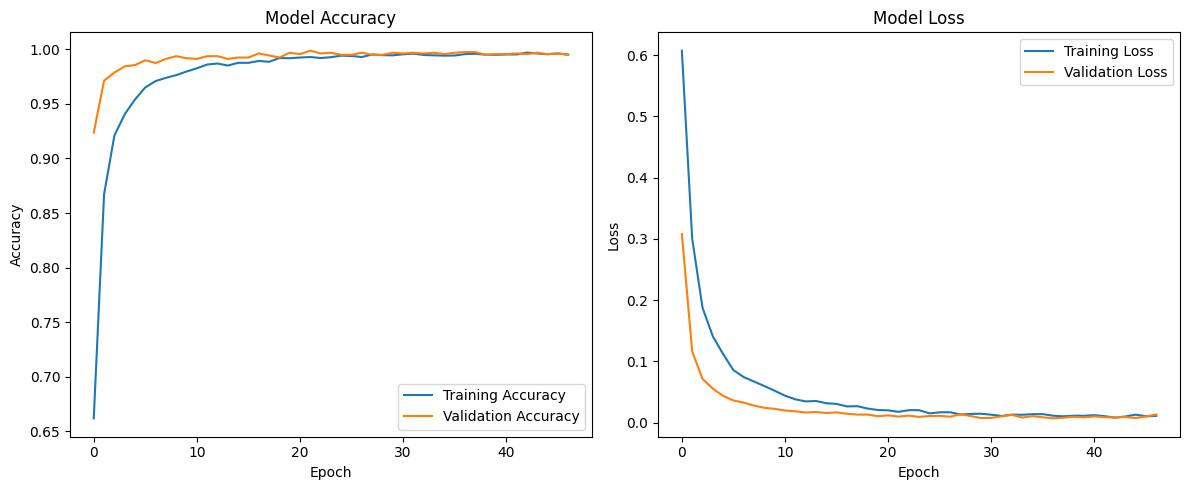

In [29]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

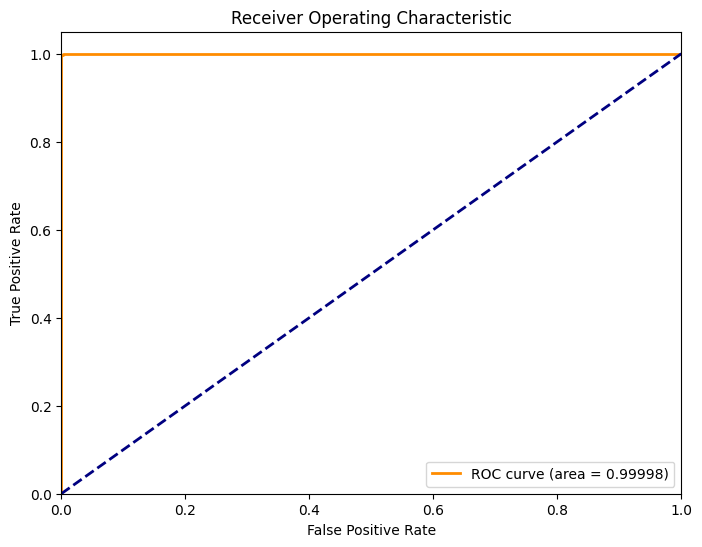

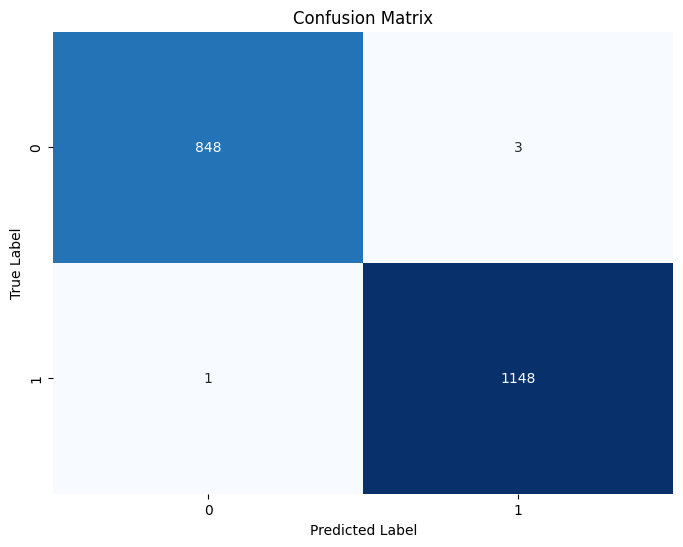

In [30]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [ ]:
model.save('diabetes_prediction_model111.h5')
print("Model saved to 'diabetes_prediction_model11.h5'")